In [1]:
import numpy as np
import pandas as pd

In [2]:
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

C:\Users\ibuce\AppData\Local\Temp\ipykernel_2396\1263004486.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [4]:
import pysal
from pysal.explore import inequality

C:\Users\ibuce\miniconda3\envs\geo_pysal\lib\site-packages\spaghetti\network.py:39: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [229]:
# read nuts shapefile to get geometry
nuts = gpd.read_file("NUTS_RG_20M_2021_3035.shp")
nuts_id = nuts[["NUTS_ID", "CNTR_CODE","geometry"]]

#### Read Dataset on GDP per cap

In [238]:
# read data on GDP per capita in Europe
gdp_data = pd.read_csv("GDP_reg.csv")

#### Handling missing values and cleaning dataset

In [249]:
# replace commas with empty strings 
gdp_data = gdp_data.replace(",", "", regex=True)

# handle missing values
gdp_data = gdp_data.replace(":", np.nan)
gdp_data = gdp_data.replace(np.nan, 0)

# convert to float
gdp_data.iloc[:, 1:] = gdp_data.iloc[:, 1:].applymap(lambda x: pd.to_numeric(x, errors="coerce"))

In [240]:
# merge datasets - we need geometry in our GDP data
gdp_merged = pd.merge(gdp_data, nuts_id, 
                        left_on="GEO (Codes)", right_on="NUTS_ID", how="left")

# exclude extra-European French regions - small and mess up viz
fr_excl = ("FRY1", "FRY2", "FRY3", "FRY4", "FRY5")
for i in fr_excl:
    gdp_merged = gdp_merged[gdp_merged["GEO (Codes)"] != i]
    
print(len(gdp_merged))    

237


In [241]:
# convert into geopandas dataframe
gdp_gdf = gpd.GeoDataFrame(gdp_merged, geometry="geometry")

# drop redundant column
gdp_gdf = gdp_gdf.drop("NUTS_ID", axis=1)

### Inequality Vizualizations
First, we explore data by creating some vizualizations of income distribution within the EU.

<AxesSubplot: xlabel='2019', ylabel='Count'>

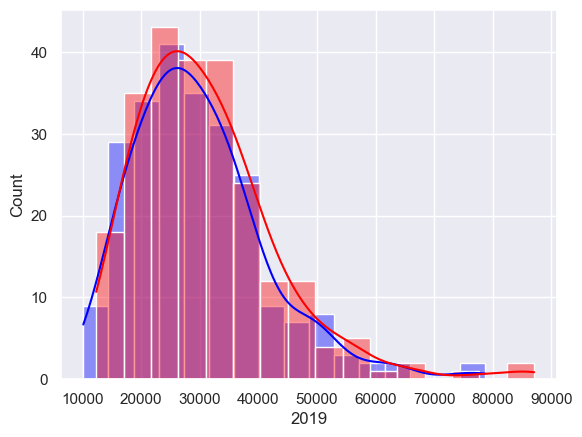

In [242]:
# histogram of income distribution
sns.set_theme()
sns.histplot(x=gdp_gdf["2019"], color="blue", alpha=.4, kde=True)
sns.histplot(x=gdp_gdf["2021"], color="red", alpha=.4, kde=True)

<AxesSubplot: xlabel='2019', ylabel='Density'>

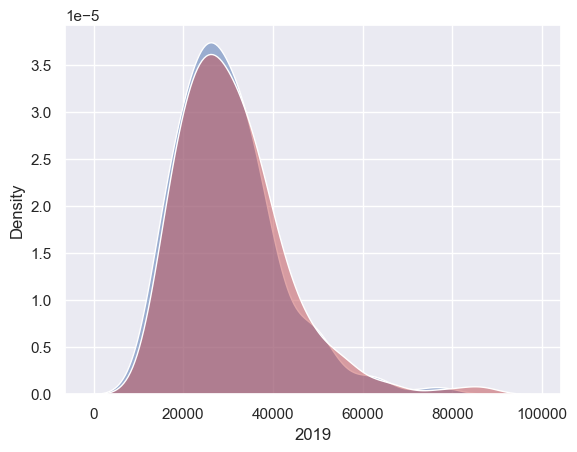

In [243]:
# kernel density plot
sns.kdeplot(x=gdp_gdf["2019"], multiple="stack", alpha=.5)
sns.kdeplot(x=gdp_gdf["2021"], multiple="stack", alpha=.5, color="r")

<AxesSubplot: xlabel='2019', ylabel='Density'>

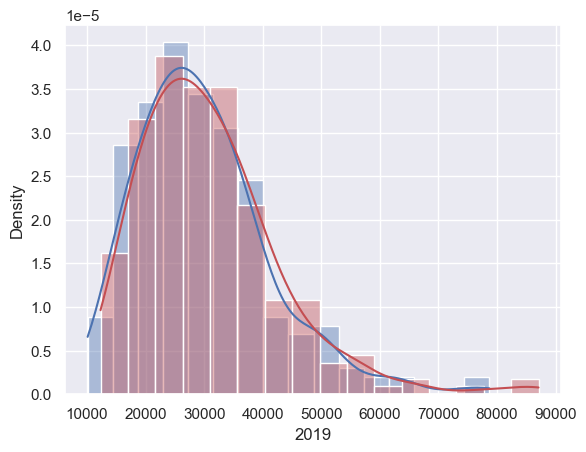

In [244]:
# normalized
sns.histplot(x=gdp_gdf["2019"], kde=True, alpha=.4, stat="density", common_norm=False)
sns.histplot(x=gdp_gdf["2021"], kde=True, alpha=.4, color="r", stat="density", common_norm=False)

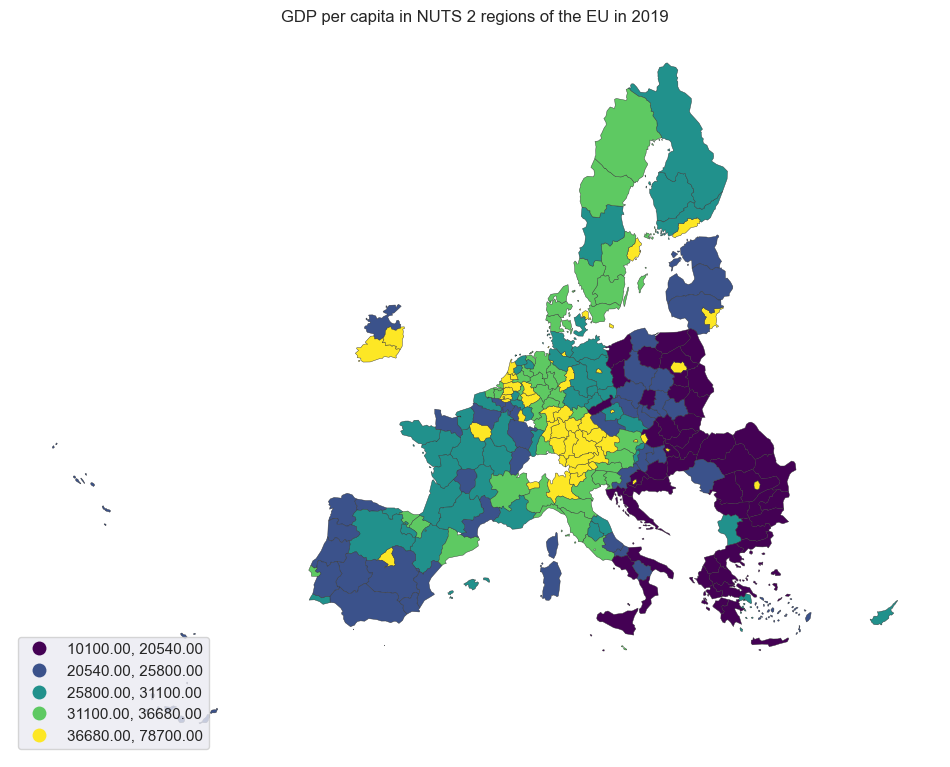

In [245]:
# Create a map of GDP per capita in regions of the EU in 2019
ax =gdp_gdf.plot(
    column="2019",
    scheme="Quantiles",
    legend=True,
    edgecolor="0.2",
    linewidth=.3,
    legend_kwds={"loc": "lower left"},
    figsize=(12, 12),
)
ax.set_axis_off()
plt.title("GDP per capita in NUTS 2 regions of the EU in 2019")
plt.show()

Text(0.5, 1.0, 'The change in GDP per capita in NUTS 2 regions of the EU between 2019 and 2021')

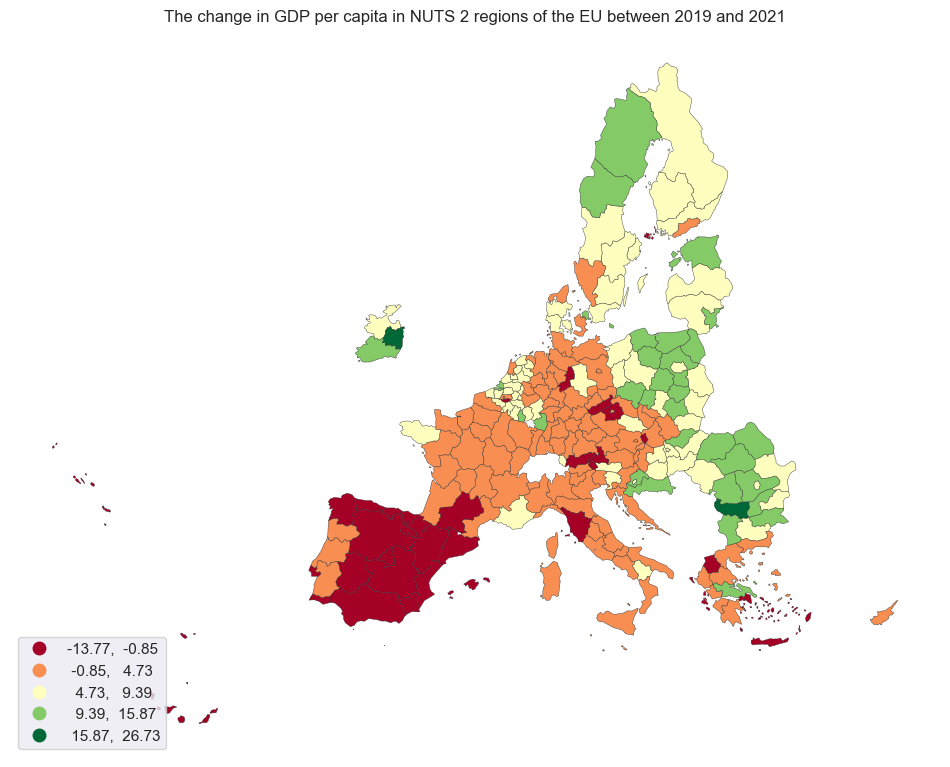

In [260]:
# Percentage difference between 2019 and 2021
gdp_gdf["diff19_21"] = ((gdp_gdf["2021"] - gdp_gdf["2019"])/gdp_gdf["2019"])*100
gdp_gdf["diff19_20"] = ((gdp_gdf["2020"] - gdp_gdf["2019"])/gdp_gdf["2019"])*100
gdp_gdf["diff20_21"] = ((gdp_gdf["2021"] - gdp_gdf["2020"])/gdp_gdf["2020"])*100

# Create a map: change in GDP per capita between 2019 and 2021
ax =gdp_gdf.plot(
    column="diff19_21",
    scheme="NaturalBreaks",
    legend=True,
    edgecolor="0.2",
    cmap="RdYlGn",
    linewidth=.3,
    legend_kwds={"loc": "lower left"},
    figsize=(12, 12),
)

ax.set_axis_off()
plt.title("The change in GDP per capita in NUTS 2 regions of the EU between 2019 and 2021")

In [ ]:
# Top 20 richest regions in 2019
top20_19 = gdp_gdf.nlargest(20, "2019")
top20_19 = top20_19[["GEO (Codes)", "CNTR_CODE", "2019"]]
print(top20_19)

# Top 20 richest regions in 2021
tail20_19 = gdp_gdf.nsmallest(20, "2019")
tail20_19 = tail20_19[["GEO (Codes)", "CNTR_CODE", "2019"]]
print(tail20_19)

### GDP as percentage of EU average
We load another dataset, also from Eurostat to explore the income differences across the EU in terms of percentage of the average GDP in the EU.

In [222]:
# read data on GDP per capita as percentage of EU average
gdp_rel = pd.read_csv("gdp_rel.csv")

# replace commas with empty strings 
gdp_rel = gdp_rel.replace(",", "", regex=True)

# handle missing values
gdp_rel=gdp_rel.replace(":", np.nan)
gdp_rel = gdp_rel.replace(np.nan, 0)

# convert to float
gdp_rel.iloc[:, 1:] = gdp_rel.iloc[:, 1:].applymap(lambda x: pd.to_numeric(x, errors="coerce"))
gdp_rel.head()

# merge datasets - we need geometry in our GDP data
gdp_rel_merged = pd.merge(gdp_rel, nuts_id, 
                        left_on="GEO (Codes)", right_on="NUTS_ID", how="left")

# exclude extra-European French regions - small and mess up viz
fr_excl = ("FRY1", "FRY2", "FRY3", "FRY4", "FRY5")
for i in fr_excl:
    gdp_rel_merged = gdp_rel_merged[gdp_rel_merged["GEO (Codes)"] != i]
    
# convert into geopandas dataframe
gdp_rel_gdf = gpd.GeoDataFrame(gdp_rel_merged, geometry="geometry")

# drop redundant column
gdp_rel_gdf = gdp_rel_gdf.drop("NUTS_ID", axis=1)

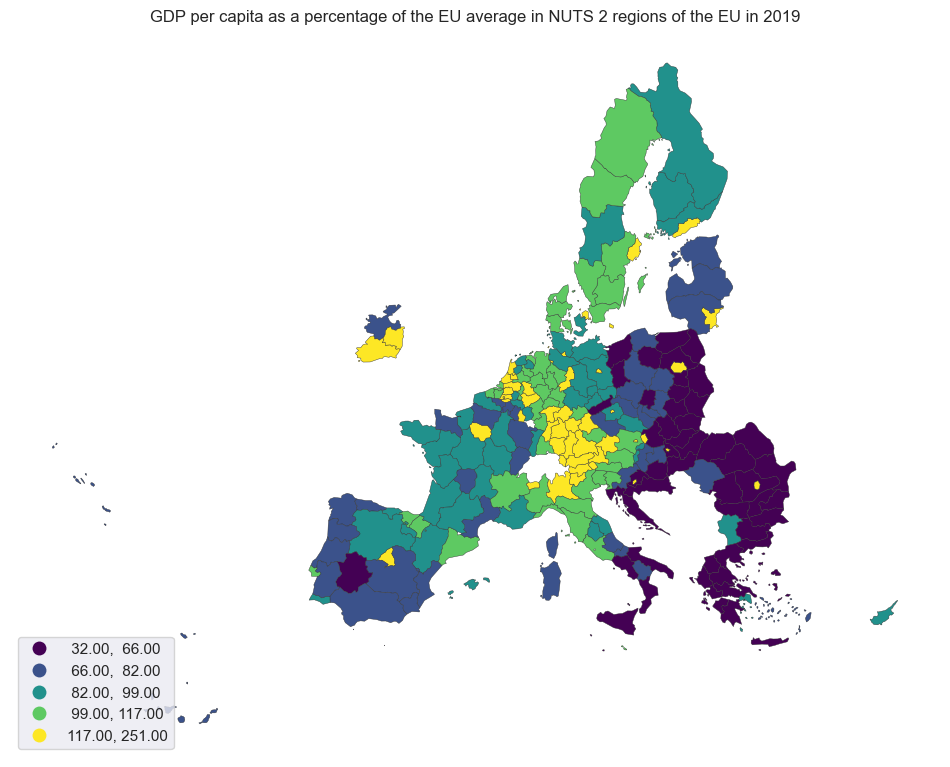

In [250]:
# Create a map for 2019
ax = gdp_rel_gdf.plot(
    column="2019",
    scheme="Quantiles",
    legend=True,
    edgecolor="0.2",
    linewidth=.3,
    legend_kwds={"loc": "lower left"},
    figsize=(12, 12),
)
ax.set_axis_off()
plt.title("GDP per capita as a percentage of the EU average in NUTS 2 regions of the EU in 2019")
plt.show()

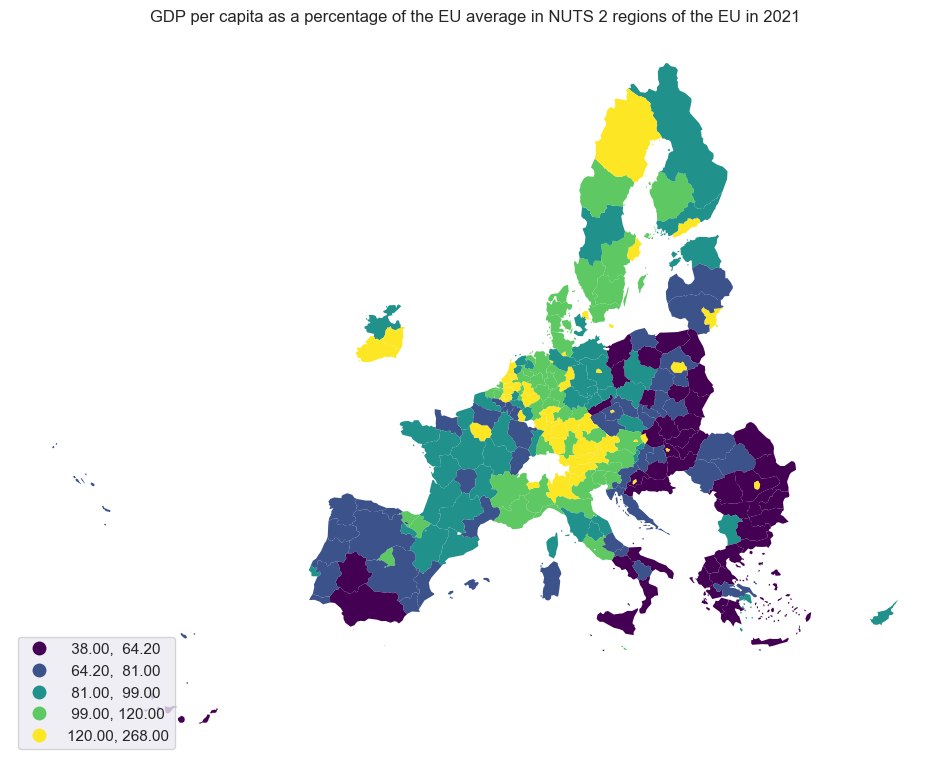

In [248]:
# Create a map for 2021
ax = gdp_rel_gdf.plot(
    column="2021",
    scheme="Quantiles",
    legend=True,
    edgecolor="none",
    legend_kwds={"loc": "lower left"},
    figsize=(12, 12),
)
ax.set_axis_off()
plt.title("GDP per capita as a percentage of the EU average in NUTS 2 regions of the EU in 2021")
plt.show()

## Measures of Inequality

### 1 20:20 Ratio
Ratio of the 80th percentile to 20th percentile of income distribution.

In [69]:
# Measures of inequality: 20:20 ratio

# obtain 20th and 80th percentile of income distribution of EU regions
top20_19, bottom20_19 = gdp_gdf["2019"].quantile([0.8, 0.2])
top20_21, bottom20_21 = gdp_gdf["2021"].quantile([0.8, 0.2])

# ratio of top20 to bottom20
ratio_19 = top20_19/bottom20_19
ratio_21 = top20_21/bottom20_21

print(ratio_19)
print(ratio_21)

2.189090909090909
2.154651162790698


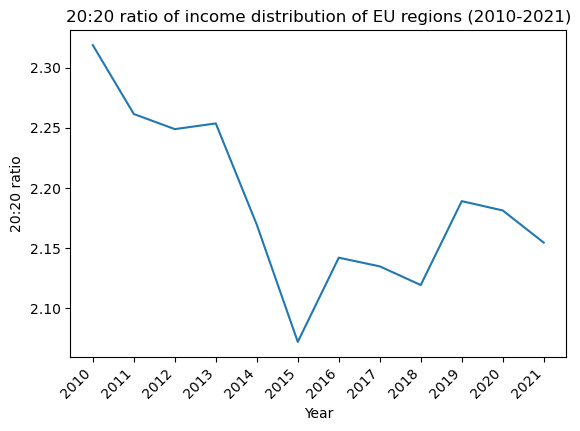

In [70]:
# define a function which calculates this ratio
def ratio20(values):
    top20, bottom20 = values.quantile([0.8, 0.2])
    return top20/bottom20

# generate a range of strings from 2010 to 2021
years = np.arange(2010, 2022).astype(str)
# Compute 20:20 ratio for every year
ratio_2020 = gdp_gdf[years].apply(ratio20, axis=0)
# Plot evolution of 20:20 ratio
ax = plt.plot(years, ratio_2020)

# Grab figure generated in the plot
figure = plt.gcf()
# Add title
plt.title("20:20 ratio of income distribution of EU regions (2010-2021)")
# Replace tick labels with every other year
plt.xticks(years)
# Set vertical label
plt.ylabel("20:20 ratio")
# Set horizontal label
plt.xlabel("Year")
# Rotate year labels
figure.autofmt_xdate(rotation=45)

plt.show()

### 2 Gini Index

##### Lorenz curve
Gini index is a widely used measure of income inequality. A related concept is Lorenz curve which illustrates how actual income distribution deviates from the straight line representing perfect equality. This means that share of wealth owned is proportional to the share of population. Gini index is the gap between perfect equality and actual income distribution.

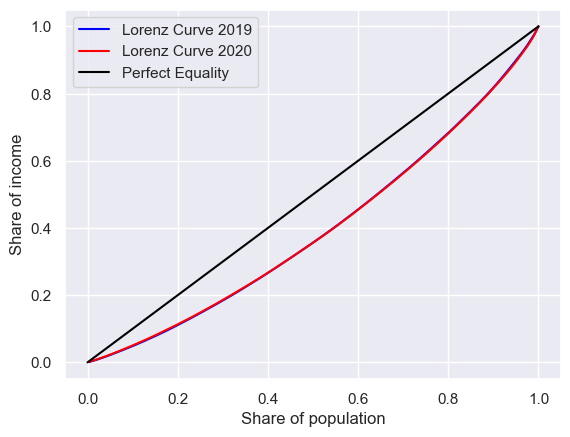

In [259]:
# Lorenz curve for 2019 and 2021
n = len(gdp_gdf)
share = np.arange(1, n + 1) / n

# cumulative distribution of incomes (2019)
incomes19 = gdp_gdf["2019"].sort_values()
shares19 = incomes19 / incomes19.sum()
cumulative_share19 = shares19.cumsum()

# cumulative distribution of incomes (2021)
incomes21 = gdp_gdf["2021"].sort_values()
shares21 = incomes21 / incomes21.sum()
cumulative_share21 = shares21.cumsum()

# Plot Lorenz curve for 2019
f, ax = plt.subplots()
# Plot Lorenz Curve
ax.plot(share, cumulative_share19, color="blue", label="Lorenz Curve 2019")
ax.plot(share, cumulative_share21, color="red", label="Lorenz Curve 2020")
# Plot line of perfect equality
ax.plot((0, 1), (0, 1), color="black", label="Perfect Equality")
# Label horizontal axis
ax.set_xlabel("Share of population")
# Label vertical axis
ax.set_ylabel("Share of income")
# Add legend
ax.legend()

plt.show()

##### Gini Coefficient
Gini coefficient represents the area between the Lorenz curve and the line of perfect equality. We use a function from the PySAL Inequality library to calculate the Gini Coefficient.

In [253]:
# Calculate Gini Coefficient
g19 = inequality.gini.Gini(gdp_gdf["2019"].values)
g21 = inequality.gini.Gini(gdp_gdf["2021"].values)

# Extract the Coefficient
print(g19.g)
print(g21.g)

0.20605500072286226
0.20662364428998506


In [254]:
# Gini coefficient by column
def gini_by_col(column):
    return inequality.gini.Gini(column.values).g

# generate a range of strings from 2010 to 2021
years = np.arange(2010, 2022).astype(str)

# apply to our data
gdp_gdf[years] = gdp_gdf[years].apply(pd.to_numeric)
inequalities = (
    gdp_gdf[years].apply(gini_by_col, axis=0).to_frame("gini")
)

print(ginis)

          gini
2010  0.270203
2011  0.268786
2012  0.261005
2013  0.259966
2014  0.242635
2015  0.241404
2016  0.240638
2017  0.237480
2018  0.237575
2019  0.252103
2020  0.253728
2021  0.273551


<AxesSubplot: >

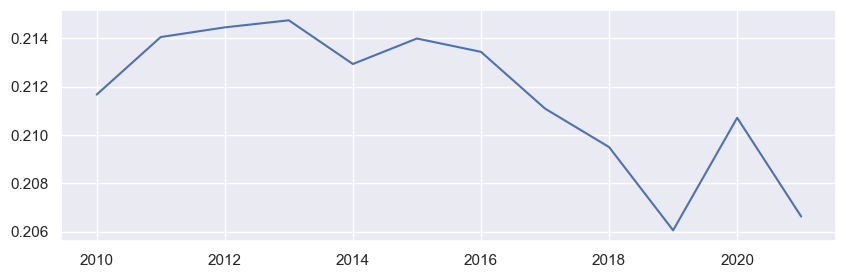

In [255]:
# plot Gini index
inequalities["gini"].plot(figsize=(10, 3))

### 2 Theil Index

In [96]:
# definea function which calculates Theil index per column
def theil(column):
    return inequality.theil.Theil(column.values).T

inequalities["theil"] = gdp_gdf[years].apply(theil, axis=0)

<AxesSubplot: >

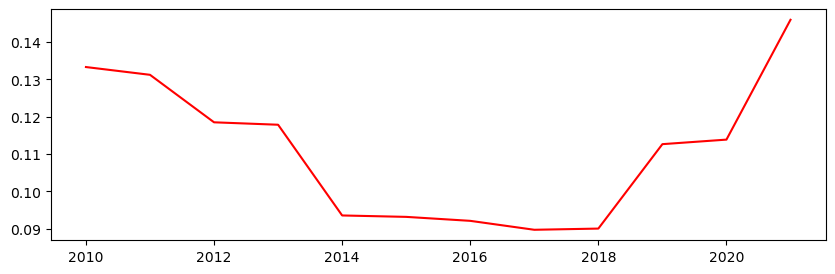

In [100]:
# plot Theil index
inequalities["theil"].plot(color="red", figsize=(10, 3))

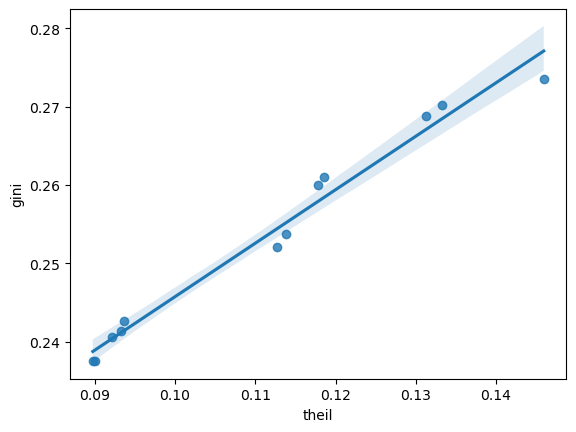

In [102]:
# plot Theil and Gini against each other
_ = sns.regplot(x="theil", y="gini", data=inequalities)

### 3 Spatial Inequality
#### 3.1 Spatial Autocorrelation
Measures of spatial autocorrelation allow us to examine to what extent is spatial distribution of incomes concentrated over space.

In [109]:
from pysal.lib import weights
from pysal.explore import esda

In [117]:
# obtain spatial weights
wq = weights.Queen.from_dataframe(gdp_gdf)

# moran statistics
def moran_by_col(y, w=wq):
    mo = esda.Moran(y, w=w)
    mo_s = pd.Series(
        {"I": mo.I},
    )
    return mo_s

inequalities["I"] = gdp_gdf[years].apply(moran_by_col, axis=0).T

inequalities.head()

('WARNING: ', 73, ' is an island (no neighbors)')
('WARNING: ', 74, ' is an island (no neighbors)')
('WARNING: ', 75, ' is an island (no neighbors)')
('WARNING: ', 81, ' is an island (no neighbors)')
('WARNING: ', 98, ' is an island (no neighbors)')
('WARNING: ', 101, ' is an island (no neighbors)')
('WARNING: ', 102, ' is an island (no neighbors)')
('WARNING: ', 103, ' is an island (no neighbors)')
('WARNING: ', 125, ' is an island (no neighbors)')
('WARNING: ', 149, ' is an island (no neighbors)')
('WARNING: ', 150, ' is an island (no neighbors)')
('WARNING: ', 151, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 208, ' is an island (no neighbors)')
('WARNING: ', 209, ' is an island (no neighbors)')
('WARNING: ', 228, ' is an island (no neighbors)')


,gini,theil,I,I-P value
2010,0.270203,0.133289,0.561480,0.001
2011,0.268786,0.131211,0.564982,0.001
2012,0.261005,0.118503,0.541048,0.001
2013,0.259966,0.117852,0.530098,0.001
2014,0.242635,0.093578,0.580527,0.001


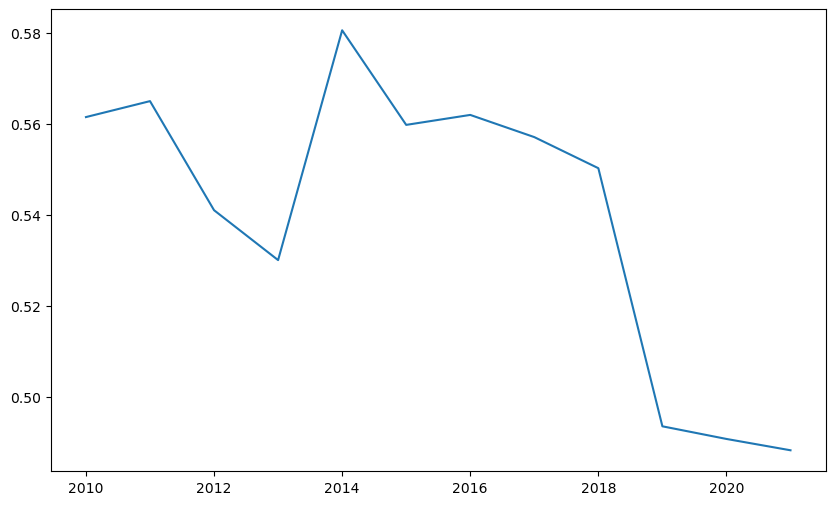

In [118]:
# create a plot
inequalities["I"].plot(figsize=(10, 6))
plt.show()

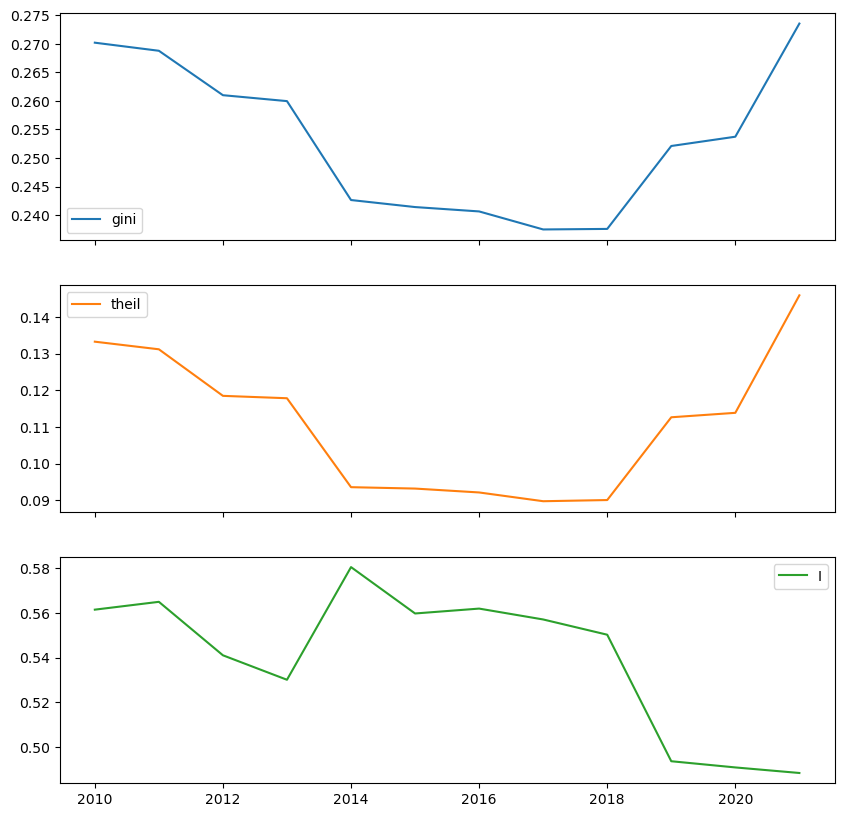

In [119]:
# Visualize all inequality measures
inequalities[["gini", "theil", "I"]].plot(subplots=True, figsize=(10, 10))
plt.show()

#### 4.2 Regional Decomposition of Inequality

In [ ]:
# Define EU macroregions: dictianary which maps macroregion to country codes
macroregions = {
    "West": ["BE", "FR", "NL", "LU", "GB", "IM", "IE"],
    "South": ["PT", "ES", "AD", "IT", "GR", "MC", "SM", "VA"],
    "Central": ["DE", "CH", "LI", "AT", "CZ", "PL", "SK","SI", "HU"],
    "East": [ "HR", "RO", "BG", "CY", "EE","LV", "LT"],
    "North": ["DK", "SE", "N0", "FI", "IS"]
}

# Create a column for macroregion
gdp_gdf["Macroregion"] = gdp_gdf["CNTR_CODE"].map(
    {c: r for r, codes in macroregions.items() for c in codes}
)

gdp_gdf = gdp_gdf.drop("REGION", axis=1)

Text(0.5, 1.0, 'EU Macroregions')

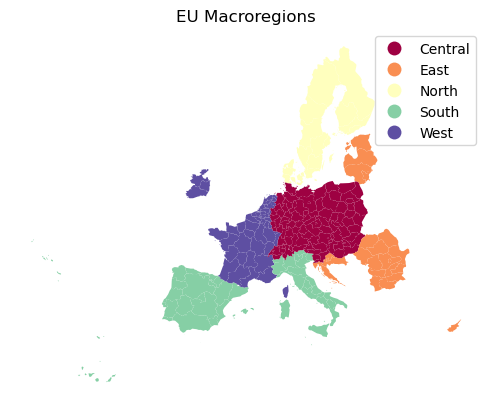

In [146]:
ax = gdp_gdf.plot(column="Macroregion", categorical= True,
                  legend=True, cmap="Spectral", linewidth=.5)
ax.set_axis_off()
ax.set_title("EU Macroregions")

<AxesSubplot: >

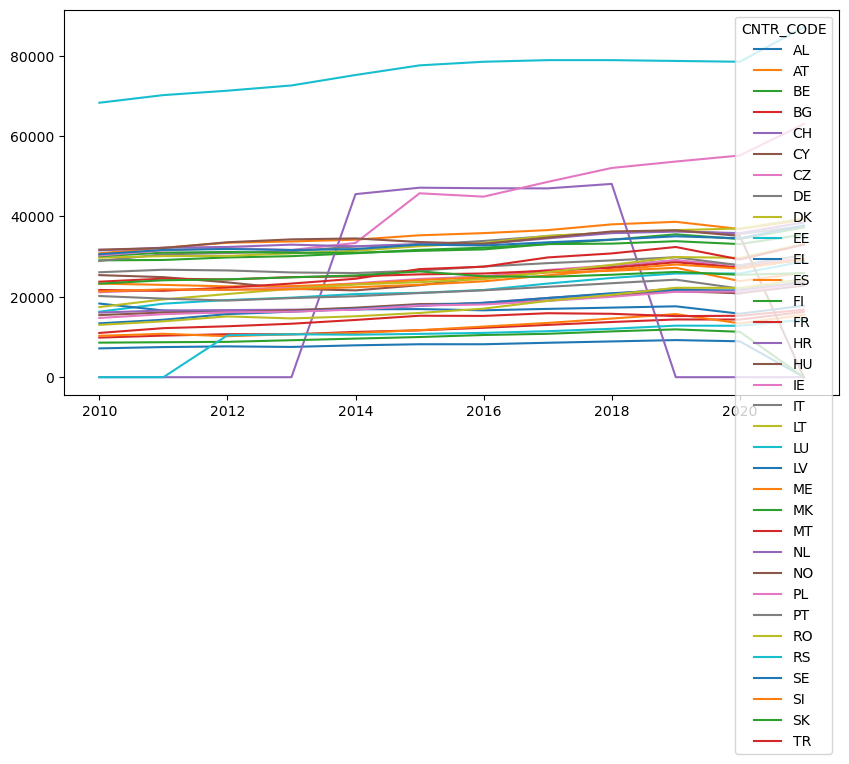

In [153]:
# average income by countries
cmeans = gdp_gdf.groupby(by="CNTR_CODE").mean()[years]
cmeans = cmeans.dropna()
cmeans.T.plot.line(figsize=(10, 5))

<AxesSubplot: >

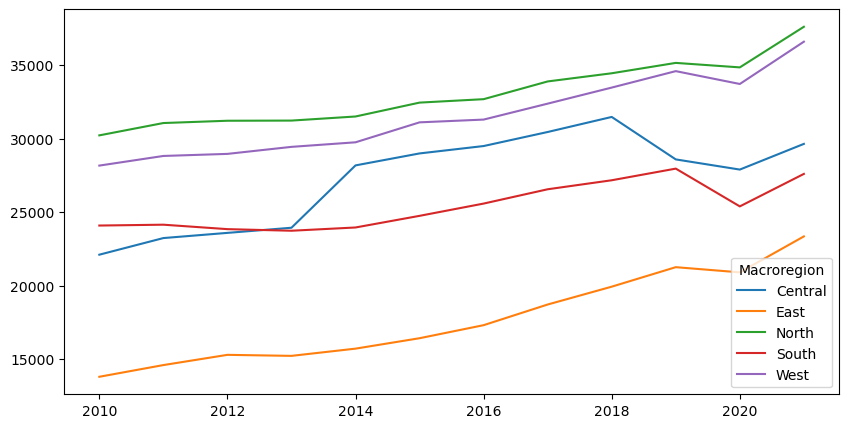

In [154]:
# average income by countries
rmeans = gdp_gdf.groupby(by="Macroregion").mean()[years]
rmeans = rmeans.dropna()
rmeans.T.plot.line(figsize=(10, 5))

In [156]:
# Theil T: within/between decomposition

# Countries
theil_c = inequality.theil.TheilD(
    gdp_gdf[years].values, gdp_gdf["CNTR_CODE"])

# Macroregions
theil_c = inequality.theil.TheilD(
    gdp_gdf[years].values, gdp_gdf.Macroregion
)

TypeError: '<' not supported between instances of 'float' and 'str'